# WeatherPy
***

## Analysis

### Methodology
- 1835 samples gathered by picking 20 random longitudinal coordinates from each latitude (-90 to +90)
- Used citipy library to find nearest city / country code for each latitude / longitude combination, keeping only unique cities
- Fed city / country code combination to OpenWeather API -- returned data for 1,617 cities (88%).

### Observations
- The sample generally falls between 75S and 75N degrees latitude, probably because of the lack of human habitation at the poles (the north pole is entirely ocean, Antarctica has no cities).
- Temperature displays a distinct boomerang pattern. The southern hemisphere is entering autumn, so temperatures trend higher overall than the northern hemisphere, which is now entering spring. However, there is a clear trend on both sides toward higher temperatures as the latitudes near the equator.
- There seems to be a strong band of high humidity (between 80% and 100%) across the entire sample. However, there seems to be a higher relative proportion of cities immediately around the equator (between the Tropics of Cancer and Capricorn) with higher humidity. Interestingly, there seem to be two clusters around 25N and 25S -- perhaps because of the location of the Sahara (23N) and the Kalahari (23S) deserts? 
- Cloud cover does not seem to be correlated with latitude at all, but there does seem to be a cluster of lower wind speeds right over the equator.

In [56]:
import openweathermapy
from citipy import citipy
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import requests
from config import api_key
from collections import defaultdict
import json
from matplotlib import style
style.use('fivethirtyeight')
import time
import datetime

In [57]:
# set min/max coords for randomized search of cities
max_latitude = 90
min_latitude = -90
max_longitude = 180
min_longitude = -180

cities = []

#for latitude in range(min_latitude, max_latitude, 1):
for latitude in np.linspace(min_latitude, max_latitude, num=360, endpoint=True):
    for _ in range(1, 21):
        lng = random.uniform(min_longitude, max_longitude)
        lat = random.uniform(latitude, latitude + 1)
        city = citipy.nearest_city(lat, lng)
        city_data = f'{city.city_name},{city.country_code}'
        if city_data not in cities:
            cities.append(city_data)
            
#the free api only allows 60 calls per minute, so divide into 34 samples. This should get ~55 cities per split.
samples = np.array_split(cities, 34)

print("City Location Complete")

City Location Complete


In [58]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={api_key}&units={units}&q="

# set up dictionary to hold data
city_data_dict = defaultdict(list)

divider = f'*********************************'
print(divider)
print('* BEGINNING DATA RETRIEVAL..... *')
print(divider)

for index, target_cities in enumerate(samples):
    for idx, target_city in enumerate(target_cities):
        print(f'Processing Record {idx} of Set {index} | {target_city}')
        response = requests.get(query_url + target_city)
        response_data = response.json()

        #this is not a particularly pythonic way to build an exception, but in this program, we want all the data
        #or none of it. So if we get a 200 but there is a problem with one of the fields in the API, we do not want
        #it getting in the table. Dump the json() and troubleshoot. If we get anything but a 200, let us know about it.
        #It is mostly likely a 404 message, telling us it can't find the city. We will not load any data for a city we
        #can't find.
        if response.status_code == 200:
            print(f'Data found (status code: {response.status_code}) | {target_city}')
            try:
                city_data_dict['city_name'].append(response_data['name'])
                city_data_dict['city_country_code'].append(response_data['sys']['country'])
                city_data_dict['city_id'].append(response_data['id'])
                city_data_dict['city_lat'].append(response_data['coord']['lat'])
                city_data_dict['city_lng'].append(response_data['coord']['lon'])
                city_data_dict['city_max_temp'].append(response_data['main']['temp_max'])
                city_data_dict['city_humidity'].append(response_data['main']['humidity'])
                city_data_dict['city_wind_speed'].append(response_data['wind']['speed'])
                city_data_dict['city_cloud_cover'].append(response_data['clouds']['all'])
                city_data_dict['record_dt'].append(response_data['dt'])
                print(f'Data loaded successfully | {target_city}')
                print(divider)
            except KeyError:
                print(f'We got a good response (status code: {response.status_code}), but did not receive good info. \
                | {target_city }')
                print(f'API Response: ')
                print(json.dumps(response_data))
        else:
            try:
                print(f"ERROR: Data retrieval unsuccessful for {target_city}. Code: {response_data['cod']} \
                      MSG: {response_data['message']}")
            except KeyError:
                print(f'SEVERE ERROR: Data retrieval unsuccessful for {target_city}. Code: {response.status_code}')
    print("Sleeping 60 seconds before next round to avoid usage limits")
    time.sleep(60)
    
print(divider)
print("* DATA COLLECTION COMPLETE..... ")        
              


    

*********************************
* BEGINNING DATA RETRIEVAL..... *
*********************************
Processing Record 0 of Set 0 | hermanus,za
Data found (status code: 200) | hermanus,za
Data loaded successfully | hermanus,za
*********************************
Processing Record 1 of Set 0 | ushuaia,ar
Data found (status code: 200) | ushuaia,ar
Data loaded successfully | ushuaia,ar
*********************************
Processing Record 2 of Set 0 | albany,au
Data found (status code: 200) | albany,au
Data loaded successfully | albany,au
*********************************
Processing Record 3 of Set 0 | mataura,pf
ERROR: Data retrieval unsuccessful for mataura,pf. Code: 404                       MSG: city not found
Processing Record 4 of Set 0 | taolanaro,mg
ERROR: Data retrieval unsuccessful for taolanaro,mg. Code: 404                       MSG: city not found
Processing Record 5 of Set 0 | kaitangata,nz
Data found (status code: 200) | kaitangata,nz
Data loaded successfully | kaitangata,nz
*

Data found (status code: 200) | rio grande,br
Data loaded successfully | rio grande,br
*********************************
Processing Record 52 of Set 0 | wanaka,nz
Data found (status code: 200) | wanaka,nz
Data loaded successfully | wanaka,nz
*********************************
Processing Record 53 of Set 0 | laguna,br
ERROR: Data retrieval unsuccessful for laguna,br. Code: 404                       MSG: city not found
Sleeping 60 seconds before next round to avoid usage limits
Processing Record 0 of Set 1 | ancud,cl
Data found (status code: 200) | ancud,cl
Data loaded successfully | ancud,cl
*********************************
Processing Record 1 of Set 1 | hastings,nz
Data found (status code: 200) | hastings,nz
Data loaded successfully | hastings,nz
*********************************
Processing Record 2 of Set 1 | otane,nz
Data found (status code: 200) | otane,nz
Data loaded successfully | otane,nz
*********************************
Processing Record 3 of Set 1 | launceston,au
Data found (s

Data found (status code: 200) | valparaiso,cl
Data loaded successfully | valparaiso,cl
*********************************
Processing Record 48 of Set 1 | geraldton,au
Data found (status code: 200) | geraldton,au
Data loaded successfully | geraldton,au
*********************************
Processing Record 49 of Set 1 | san luis,ar
Data found (status code: 200) | san luis,ar
Data loaded successfully | san luis,ar
*********************************
Processing Record 50 of Set 1 | constitucion,cl
Data found (status code: 200) | constitucion,cl
Data loaded successfully | constitucion,cl
*********************************
Processing Record 51 of Set 1 | mildura,au
Data found (status code: 200) | mildura,au
Data loaded successfully | mildura,au
*********************************
Processing Record 52 of Set 1 | lithgow,au
Data found (status code: 200) | lithgow,au
Data loaded successfully | lithgow,au
*********************************
Processing Record 53 of Set 1 | melo,uy
Data found (status code: 

Data found (status code: 200) | alice springs,au
Data loaded successfully | alice springs,au
*********************************
Processing Record 45 of Set 2 | victoria point,au
Data found (status code: 200) | victoria point,au
Data loaded successfully | victoria point,au
*********************************
Processing Record 46 of Set 2 | port hedland,au
Data found (status code: 200) | port hedland,au
Data loaded successfully | port hedland,au
*********************************
Processing Record 47 of Set 2 | puerto ayora,ec
Data found (status code: 200) | puerto ayora,ec
Data loaded successfully | puerto ayora,ec
*********************************
Processing Record 48 of Set 2 | palmas,br
Data found (status code: 200) | palmas,br
Data loaded successfully | palmas,br
*********************************
Processing Record 49 of Set 2 | toliary,mg
ERROR: Data retrieval unsuccessful for toliary,mg. Code: 404                       MSG: city not found
Processing Record 50 of Set 2 | tres barras,br


Data found (status code: 200) | labuhan,id
Data loaded successfully | labuhan,id
*********************************
Processing Record 43 of Set 3 | saint-paul,re
Data found (status code: 200) | saint-paul,re
Data loaded successfully | saint-paul,re
*********************************
Processing Record 44 of Set 3 | moerai,pf
Data found (status code: 200) | moerai,pf
Data loaded successfully | moerai,pf
*********************************
Processing Record 45 of Set 3 | charters towers,au
Data found (status code: 200) | charters towers,au
Data loaded successfully | charters towers,au
*********************************
Processing Record 46 of Set 3 | okakarara,na
Data found (status code: 200) | okakarara,na
Data loaded successfully | okakarara,na
*********************************
Processing Record 47 of Set 3 | hithadhoo,mv
Data found (status code: 200) | hithadhoo,mv
Data loaded successfully | hithadhoo,mv
*********************************
Processing Record 48 of Set 3 | orapa,bw
Data found (

Data found (status code: 200) | vaitape,pf
Data loaded successfully | vaitape,pf
*********************************
Processing Record 40 of Set 4 | puerto quijarro,bo
Data found (status code: 200) | puerto quijarro,bo
Data loaded successfully | puerto quijarro,bo
*********************************
Processing Record 41 of Set 4 | kalomo,zm
ERROR: Data retrieval unsuccessful for kalomo,zm. Code: 404                       MSG: city not found
Processing Record 42 of Set 4 | maceio,br
Data found (status code: 200) | maceio,br
Data loaded successfully | maceio,br
*********************************
Processing Record 43 of Set 4 | palabuhanratu,id
ERROR: Data retrieval unsuccessful for palabuhanratu,id. Code: 404                       MSG: city not found
Processing Record 44 of Set 4 | rundu,na
Data found (status code: 200) | rundu,na
Data loaded successfully | rundu,na
*********************************
Processing Record 45 of Set 4 | siavonga,zm
Data found (status code: 200) | siavonga,zm
Data l

Data found (status code: 200) | caluquembe,ao
Data loaded successfully | caluquembe,ao
*********************************
Processing Record 37 of Set 5 | itacare,br
Data found (status code: 200) | itacare,br
Data loaded successfully | itacare,br
*********************************
Processing Record 38 of Set 5 | niquelandia,br
Data found (status code: 200) | niquelandia,br
Data loaded successfully | niquelandia,br
*********************************
Processing Record 39 of Set 5 | fomboni,km
Data found (status code: 200) | fomboni,km
Data loaded successfully | fomboni,km
*********************************
Processing Record 40 of Set 5 | kawalu,id
Data found (status code: 200) | kawalu,id
Data loaded successfully | kawalu,id
*********************************
Processing Record 41 of Set 5 | nacala,mz
Data found (status code: 200) | nacala,mz
Data loaded successfully | nacala,mz
*********************************
Processing Record 42 of Set 5 | samusu,ws
ERROR: Data retrieval unsuccessful for sa

Data found (status code: 200) | xique-xique,br
Data loaded successfully | xique-xique,br
*********************************
Processing Record 35 of Set 6 | sumbe,ao
Data found (status code: 200) | sumbe,ao
Data loaded successfully | sumbe,ao
*********************************
Processing Record 36 of Set 6 | atambua,id
Data found (status code: 200) | atambua,id
Data loaded successfully | atambua,id
*********************************
Processing Record 37 of Set 6 | morros,br
Data found (status code: 200) | morros,br
Data loaded successfully | morros,br
*********************************
Processing Record 38 of Set 6 | luanda,ao
Data found (status code: 200) | luanda,ao
Data loaded successfully | luanda,ao
*********************************
Processing Record 39 of Set 6 | ambulu,id
Data found (status code: 200) | ambulu,id
Data loaded successfully | ambulu,id
*********************************
Processing Record 40 of Set 6 | passo de camaragibe,br
Data found (status code: 200) | passo de camara

Data found (status code: 200) | pauini,br
Data loaded successfully | pauini,br
*********************************
Processing Record 34 of Set 7 | soritor,pe
Data found (status code: 200) | soritor,pe
Data loaded successfully | soritor,pe
*********************************
Processing Record 35 of Set 7 | cabedelo,br
Data found (status code: 200) | cabedelo,br
Data loaded successfully | cabedelo,br
*********************************
Processing Record 36 of Set 7 | kijini,tz
Data found (status code: 200) | kijini,tz
Data loaded successfully | kijini,tz
*********************************
Processing Record 37 of Set 7 | ilebo,cd
Data found (status code: 200) | ilebo,cd
Data loaded successfully | ilebo,cd
*********************************
Processing Record 38 of Set 7 | talara,pe
Data found (status code: 200) | talara,pe
Data loaded successfully | talara,pe
*********************************
Processing Record 39 of Set 7 | porgera,pg
Data found (status code: 200) | porgera,pg
Data loaded successf

Data found (status code: 200) | lorengau,pg
Data loaded successfully | lorengau,pg
*********************************
Processing Record 33 of Set 8 | kindu,cd
Data found (status code: 200) | kindu,cd
Data loaded successfully | kindu,cd
*********************************
Processing Record 34 of Set 8 | sampit,id
Data found (status code: 200) | sampit,id
Data loaded successfully | sampit,id
*********************************
Processing Record 35 of Set 8 | mentok,id
ERROR: Data retrieval unsuccessful for mentok,id. Code: 404                       MSG: city not found
Processing Record 36 of Set 8 | manggar,id
Data found (status code: 200) | manggar,id
Data loaded successfully | manggar,id
*********************************
Processing Record 37 of Set 8 | namatanai,pg
Data found (status code: 200) | namatanai,pg
Data loaded successfully | namatanai,pg
*********************************
Processing Record 38 of Set 8 | rungata,ki
ERROR: Data retrieval unsuccessful for rungata,ki. Code: 404       

Data found (status code: 200) | kagadi,ug
Data loaded successfully | kagadi,ug
*********************************
Processing Record 32 of Set 9 | boa vista,br
Data found (status code: 200) | boa vista,br
Data loaded successfully | boa vista,br
*********************************
Processing Record 33 of Set 9 | isiolo,ke
Data found (status code: 200) | isiolo,ke
Data loaded successfully | isiolo,ke
*********************************
Processing Record 34 of Set 9 | tutoia,br
Data found (status code: 200) | tutoia,br
Data loaded successfully | tutoia,br
*********************************
Processing Record 35 of Set 9 | kijang,id
Data found (status code: 200) | kijang,id
Data loaded successfully | kijang,id
*********************************
Processing Record 36 of Set 9 | wanlaweyn,so
Data found (status code: 200) | wanlaweyn,so
Data loaded successfully | wanlaweyn,so
*********************************
Processing Record 37 of Set 9 | dumai,id
Data found (status code: 200) | dumai,id
Data loaded 

Data found (status code: 200) | kourou,gf
Data loaded successfully | kourou,gf
*********************************
Processing Record 30 of Set 10 | tibacuy,co
Data found (status code: 200) | tibacuy,co
Data loaded successfully | tibacuy,co
*********************************
Processing Record 31 of Set 10 | bangassou,cf
Data found (status code: 200) | bangassou,cf
Data loaded successfully | bangassou,cf
*********************************
Processing Record 32 of Set 10 | kloulklubed,pw
Data found (status code: 200) | kloulklubed,pw
Data loaded successfully | kloulklubed,pw
*********************************
Processing Record 33 of Set 10 | cumaribo,co
ERROR: Data retrieval unsuccessful for cumaribo,co. Code: 404                       MSG: city not found
Processing Record 34 of Set 10 | galle,lk
Data found (status code: 200) | galle,lk
Data loaded successfully | galle,lk
*********************************
Processing Record 35 of Set 10 | burica,pa
ERROR: Data retrieval unsuccessful for burica,p

Data found (status code: 200) | port blair,in
Data loaded successfully | port blair,in
*********************************
Processing Record 29 of Set 11 | babag,ph
Data found (status code: 200) | babag,ph
Data loaded successfully | babag,ph
*********************************
Processing Record 30 of Set 11 | champerico,gt
Data found (status code: 200) | champerico,gt
Data loaded successfully | champerico,gt
*********************************
Processing Record 31 of Set 11 | villa bruzual,ve
Data found (status code: 200) | villa bruzual,ve
Data loaded successfully | villa bruzual,ve
*********************************
Processing Record 32 of Set 11 | balabac,ph
Data found (status code: 200) | balabac,ph
Data loaded successfully | balabac,ph
*********************************
Processing Record 33 of Set 11 | nicoya,cr
Data found (status code: 200) | nicoya,cr
Data loaded successfully | nicoya,cr
*********************************
Processing Record 34 of Set 11 | tariba,ve
Data found (status code

Data found (status code: 200) | asosa,et
Data loaded successfully | asosa,et
*********************************
Processing Record 29 of Set 12 | cam ranh,vn
Data found (status code: 200) | cam ranh,vn
Data loaded successfully | cam ranh,vn
*********************************
Processing Record 30 of Set 12 | birao,cf
Data found (status code: 200) | birao,cf
Data loaded successfully | birao,cf
*********************************
Processing Record 31 of Set 12 | coro,ve
Data found (status code: 200) | coro,ve
Data loaded successfully | coro,ve
*********************************
Processing Record 32 of Set 12 | melfi,td
Data found (status code: 200) | melfi,td
Data loaded successfully | melfi,td
*********************************
Processing Record 33 of Set 12 | zaria,ng
Data found (status code: 200) | zaria,ng
Data loaded successfully | zaria,ng
*********************************
Processing Record 34 of Set 12 | bure,et
ERROR: Data retrieval unsuccessful for bure,et. Code: 404                    

Data found (status code: 200) | filingue,ne
Data loaded successfully | filingue,ne
*********************************
Processing Record 28 of Set 13 | manaure,co
Data found (status code: 200) | manaure,co
Data loaded successfully | manaure,co
*********************************
Processing Record 29 of Set 13 | malwan,in
ERROR: Data retrieval unsuccessful for malwan,in. Code: 404                       MSG: city not found
Processing Record 30 of Set 13 | bull savanna,jm
Data found (status code: 200) | bull savanna,jm
Data loaded successfully | bull savanna,jm
*********************************
Processing Record 31 of Set 13 | dawei,mm
Data found (status code: 200) | dawei,mm
Data loaded successfully | dawei,mm
*********************************
Processing Record 32 of Set 13 | doka,sd
Data found (status code: 200) | doka,sd
Data loaded successfully | doka,sd
*********************************
Processing Record 33 of Set 13 | edd,er
Data found (status code: 200) | edd,er
Data loaded successfull

Data found (status code: 200) | marawi,sd
Data loaded successfully | marawi,sd
*********************************
Processing Record 27 of Set 14 | arlit,ne
Data found (status code: 200) | arlit,ne
Data loaded successfully | arlit,ne
*********************************
Processing Record 28 of Set 14 | nioro,ml
ERROR: Data retrieval unsuccessful for nioro,ml. Code: 404                       MSG: city not found
Processing Record 29 of Set 14 | gigmoto,ph
Data found (status code: 200) | gigmoto,ph
Data loaded successfully | gigmoto,ph
*********************************
Processing Record 30 of Set 14 | black river,jm
Data found (status code: 200) | black river,jm
Data loaded successfully | black river,jm
*********************************
Processing Record 31 of Set 14 | faya,td
ERROR: Data retrieval unsuccessful for faya,td. Code: 404                       MSG: city not found
Processing Record 32 of Set 14 | puri,in
Data found (status code: 200) | puri,in
Data loaded successfully | puri,in
****

Data found (status code: 200) | bucerias,mx
Data loaded successfully | bucerias,mx
*********************************
Processing Record 28 of Set 15 | vega de alatorre,mx
Data found (status code: 200) | vega de alatorre,mx
Data loaded successfully | vega de alatorre,mx
*********************************
Processing Record 29 of Set 15 | chichimila,mx
Data found (status code: 200) | chichimila,mx
Data loaded successfully | chichimila,mx
*********************************
Processing Record 30 of Set 15 | basco,ph
Data found (status code: 200) | basco,ph
Data loaded successfully | basco,ph
*********************************
Processing Record 31 of Set 15 | trinidad,cu
Data found (status code: 200) | trinidad,cu
Data loaded successfully | trinidad,cu
*********************************
Processing Record 32 of Set 15 | athmallik,in
Data found (status code: 200) | athmallik,in
Data loaded successfully | athmallik,in
*********************************
Processing Record 33 of Set 15 | honolulu,us
Data

ERROR: Data retrieval unsuccessful for makung,tw. Code: 404                       MSG: city not found
Processing Record 26 of Set 16 | hirara,jp
Data found (status code: 200) | hirara,jp
Data loaded successfully | hirara,jp
*********************************
Processing Record 27 of Set 16 | latehar,in
Data found (status code: 200) | latehar,in
Data loaded successfully | latehar,in
*********************************
Processing Record 28 of Set 16 | progreso,mx
Data found (status code: 200) | progreso,mx
Data loaded successfully | progreso,mx
*********************************
Processing Record 29 of Set 16 | navolato,mx
Data found (status code: 200) | navolato,mx
Data loaded successfully | navolato,mx
*********************************
Processing Record 30 of Set 16 | panaba,mx
Data found (status code: 200) | panaba,mx
Data loaded successfully | panaba,mx
*********************************
Processing Record 31 of Set 16 | karachi,pk
Data found (status code: 200) | karachi,pk
Data loaded succ

Data found (status code: 200) | turbat,pk
Data loaded successfully | turbat,pk
*********************************
Processing Record 23 of Set 17 | rockport,us
Data found (status code: 200) | rockport,us
Data loaded successfully | rockport,us
*********************************
Processing Record 24 of Set 17 | hobe sound,us
Data found (status code: 200) | hobe sound,us
Data loaded successfully | hobe sound,us
*********************************
Processing Record 25 of Set 17 | tabuk,sa
Data found (status code: 200) | tabuk,sa
Data loaded successfully | tabuk,sa
*********************************
Processing Record 26 of Set 17 | khash,ir
Data found (status code: 200) | khash,ir
Data loaded successfully | khash,ir
*********************************
Processing Record 27 of Set 17 | north port,us
Data found (status code: 200) | north port,us
Data loaded successfully | north port,us
*********************************
Processing Record 28 of Set 17 | bayshore gardens,us
Data found (status code: 200) 

ERROR: Data retrieval unsuccessful for lasa,cn. Code: 404                       MSG: city not found
Processing Record 24 of Set 18 | marrakesh,ma
Data found (status code: 200) | marrakesh,ma
Data loaded successfully | marrakesh,ma
*********************************
Processing Record 25 of Set 18 | pinjaur,in
Data found (status code: 200) | pinjaur,in
Data loaded successfully | pinjaur,in
*********************************
Processing Record 26 of Set 18 | shenjiamen,cn
Data found (status code: 200) | shenjiamen,cn
Data loaded successfully | shenjiamen,cn
*********************************
Processing Record 27 of Set 18 | severo-kurilsk,ru
Data found (status code: 200) | severo-kurilsk,ru
Data loaded successfully | severo-kurilsk,ru
*********************************
Processing Record 28 of Set 18 | zaranj,af
Data found (status code: 200) | zaranj,af
Data loaded successfully | zaranj,af
*********************************
Processing Record 29 of Set 18 | mizdah,ly
Data found (status code: 200)

ERROR: Data retrieval unsuccessful for azimur,ma. Code: 404                       MSG: city not found
Processing Record 22 of Set 19 | abu kamal,sy
Data found (status code: 200) | abu kamal,sy
Data loaded successfully | abu kamal,sy
*********************************
Processing Record 23 of Set 19 | birjand,ir
Data found (status code: 200) | birjand,ir
Data loaded successfully | birjand,ir
*********************************
Processing Record 24 of Set 19 | muroto,jp
Data found (status code: 200) | muroto,jp
Data loaded successfully | muroto,jp
*********************************
Processing Record 25 of Set 19 | leh,in
Data found (status code: 200) | leh,in
Data loaded successfully | leh,in
*********************************
Processing Record 26 of Set 19 | lemesos,cy
ERROR: Data retrieval unsuccessful for lemesos,cy. Code: 404                       MSG: city not found
Processing Record 27 of Set 19 | camacha,pt
Data found (status code: 200) | camacha,pt
Data loaded successfully | camacha,pt

Data found (status code: 200) | borger,us
Data loaded successfully | borger,us
*********************************
Processing Record 20 of Set 20 | takestan,ir
Data found (status code: 200) | takestan,ir
Data loaded successfully | takestan,ir
*********************************
Processing Record 21 of Set 20 | pahrump,us
Data found (status code: 200) | pahrump,us
Data loaded successfully | pahrump,us
*********************************
Processing Record 22 of Set 20 | kargil,in
Data found (status code: 200) | kargil,in
Data loaded successfully | kargil,in
*********************************
Processing Record 23 of Set 20 | asopos,gr
Data found (status code: 200) | asopos,gr
Data loaded successfully | asopos,gr
*********************************
Processing Record 24 of Set 20 | morristown,us
Data found (status code: 200) | morristown,us
Data loaded successfully | morristown,us
*********************************
Processing Record 25 of Set 20 | sunrise manor,us
Data found (status code: 200) | sunr

Data found (status code: 200) | cedar city,us
Data loaded successfully | cedar city,us
*********************************
Processing Record 18 of Set 21 | cehegin,es
Data found (status code: 200) | cehegin,es
Data loaded successfully | cehegin,es
*********************************
Processing Record 19 of Set 21 | kamaishi,jp
Data found (status code: 200) | kamaishi,jp
Data loaded successfully | kamaishi,jp
*********************************
Processing Record 20 of Set 21 | montrose,us
Data found (status code: 200) | montrose,us
Data loaded successfully | montrose,us
*********************************
Processing Record 21 of Set 21 | ahar,ir
Data found (status code: 200) | ahar,ir
Data loaded successfully | ahar,ir
*********************************
Processing Record 22 of Set 21 | mus,tr
Data found (status code: 200) | mus,tr
Data loaded successfully | mus,tr
*********************************
Processing Record 23 of Set 21 | colares,pt
Data found (status code: 200) | colares,pt
Data loaded 

Data found (status code: 200) | mira,pt
Data loaded successfully | mira,pt
*********************************
Processing Record 16 of Set 22 | youngstown,us
Data found (status code: 200) | youngstown,us
Data loaded successfully | youngstown,us
*********************************
Processing Record 17 of Set 22 | susanville,us
Data found (status code: 200) | susanville,us
Data loaded successfully | susanville,us
*********************************
Processing Record 18 of Set 22 | salou,es
Data found (status code: 200) | salou,es
Data loaded successfully | salou,es
*********************************
Processing Record 19 of Set 22 | sorso,it
Data found (status code: 200) | sorso,it
Data loaded successfully | sorso,it
*********************************
Processing Record 20 of Set 22 | eureka,us
Data found (status code: 200) | eureka,us
Data loaded successfully | eureka,us
*********************************
Processing Record 21 of Set 22 | liaoyang,cn
Data found (status code: 200) | liaoyang,cn
Data

Data found (status code: 200) | yarmouth,ca
Data loaded successfully | yarmouth,ca
*********************************
Processing Record 14 of Set 23 | halifax,ca
Data found (status code: 200) | halifax,ca
Data loaded successfully | halifax,ca
*********************************
Processing Record 15 of Set 23 | tokmak,kg
ERROR: Data retrieval unsuccessful for tokmak,kg. Code: 404                       MSG: city not found
Processing Record 16 of Set 23 | siena,it
Data found (status code: 200) | siena,it
Data loaded successfully | siena,it
*********************************
Processing Record 17 of Set 23 | hovd,mn
Data found (status code: 200) | hovd,mn
Data loaded successfully | hovd,mn
*********************************
Processing Record 18 of Set 23 | bay city,us
Data found (status code: 200) | bay city,us
Data loaded successfully | bay city,us
*********************************
Processing Record 19 of Set 23 | canandaigua,us
Data found (status code: 200) | canandaigua,us
Data loaded success

Data found (status code: 200) | sault sainte marie,ca
Data loaded successfully | sault sainte marie,ca
*********************************
Processing Record 13 of Set 24 | aberdeen,us
Data found (status code: 200) | aberdeen,us
Data loaded successfully | aberdeen,us
*********************************
Processing Record 14 of Set 24 | praia da vitoria,pt
Data found (status code: 200) | praia da vitoria,pt
Data loaded successfully | praia da vitoria,pt
*********************************
Processing Record 15 of Set 24 | belle fourche,us
Data found (status code: 200) | belle fourche,us
Data loaded successfully | belle fourche,us
*********************************
Processing Record 16 of Set 24 | marystown,ca
Data found (status code: 200) | marystown,ca
Data loaded successfully | marystown,ca
*********************************
Processing Record 17 of Set 24 | parry sound,ca
Data found (status code: 200) | parry sound,ca
Data loaded successfully | parry sound,ca
*********************************
Pr

Data found (status code: 200) | yichun,cn
Data loaded successfully | yichun,cn
*********************************
Processing Record 9 of Set 25 | mala tokmachka,ua
Data found (status code: 200) | mala tokmachka,ua
Data loaded successfully | mala tokmachka,ua
*********************************
Processing Record 10 of Set 25 | moron,mn
Data found (status code: 200) | moron,mn
Data loaded successfully | moron,mn
*********************************
Processing Record 11 of Set 25 | longjiang,cn
Data found (status code: 200) | longjiang,cn
Data loaded successfully | longjiang,cn
*********************************
Processing Record 12 of Set 25 | chernyshkovskiy,ru
Data found (status code: 200) | chernyshkovskiy,ru
Data loaded successfully | chernyshkovskiy,ru
*********************************
Processing Record 13 of Set 25 | amos,ca
Data found (status code: 200) | amos,ca
Data loaded successfully | amos,ca
*********************************
Processing Record 14 of Set 25 | tsimlyansk,ru
Data found

Data found (status code: 200) | oleksandrivka,ua
Data loaded successfully | oleksandrivka,ua
*********************************
Processing Record 6 of Set 26 | manzhouli,cn
Data found (status code: 200) | manzhouli,cn
Data loaded successfully | manzhouli,cn
*********************************
Processing Record 7 of Set 26 | atikokan,ca
Data found (status code: 200) | atikokan,ca
Data loaded successfully | atikokan,ca
*********************************
Processing Record 8 of Set 26 | dolbeau,ca
ERROR: Data retrieval unsuccessful for dolbeau,ca. Code: 404                       MSG: city not found
Processing Record 9 of Set 26 | emba,kz
ERROR: Data retrieval unsuccessful for emba,kz. Code: 404                       MSG: city not found
Processing Record 10 of Set 26 | gravelbourg,ca
Data found (status code: 200) | gravelbourg,ca
Data loaded successfully | gravelbourg,ca
*********************************
Processing Record 11 of Set 26 | krasnyy chikoy,ru
Data found (status code: 200) | krasnyy 

Data found (status code: 200) | dryden,ca
Data loaded successfully | dryden,ca
*********************************
Processing Record 4 of Set 27 | teeli,ru
Data found (status code: 200) | teeli,ru
Data loaded successfully | teeli,ru
*********************************
Processing Record 5 of Set 27 | barnstaple,gb
Data found (status code: 200) | barnstaple,gb
Data loaded successfully | barnstaple,gb
*********************************
Processing Record 6 of Set 27 | veere,nl
Data found (status code: 200) | veere,nl
Data loaded successfully | veere,nl
*********************************
Processing Record 7 of Set 27 | homberg,de
Data found (status code: 200) | homberg,de
Data loaded successfully | homberg,de
*********************************
Processing Record 8 of Set 27 | ereymentau,kz
Data found (status code: 200) | ereymentau,kz
Data loaded successfully | ereymentau,kz
*********************************
Processing Record 9 of Set 27 | neepawa,ca
Data found (status code: 200) | neepawa,ca
Data 

ERROR: Data retrieval unsuccessful for podbelsk,ru. Code: 404                       MSG: city not found
Processing Record 2 of Set 28 | llangefni,gb
Data found (status code: 200) | llangefni,gb
Data loaded successfully | llangefni,gb
*********************************
Processing Record 3 of Set 28 | jasper,ca
Data found (status code: 200) | jasper,ca
Data loaded successfully | jasper,ca
*********************************
Processing Record 4 of Set 28 | kamen-na-obi,ru
Data found (status code: 200) | kamen-na-obi,ru
Data loaded successfully | kamen-na-obi,ru
*********************************
Processing Record 5 of Set 28 | ust-ordynskiy,ru
Data found (status code: 200) | ust-ordynskiy,ru
Data loaded successfully | ust-ordynskiy,ru
*********************************
Processing Record 6 of Set 28 | ekhabi,ru
Data found (status code: 200) | ekhabi,ru
Data loaded successfully | ekhabi,ru
*********************************
Processing Record 7 of Set 28 | lloydminster,ca
Data found (status code: 

Data found (status code: 200) | waterfoot,gb
Data loaded successfully | waterfoot,gb
*********************************
Sleeping 60 seconds before next round to avoid usage limits
Processing Record 0 of Set 29 | krasnyy mayak,ru
ERROR: Data retrieval unsuccessful for krasnyy mayak,ru. Code: 404                       MSG: city not found
Processing Record 1 of Set 29 | esso,ru
Data found (status code: 200) | esso,ru
Data loaded successfully | esso,ru
*********************************
Processing Record 2 of Set 29 | fairview,ca
Data found (status code: 200) | fairview,ca
Data loaded successfully | fairview,ca
*********************************
Processing Record 3 of Set 29 | nizhnekamsk,ru
Data found (status code: 200) | nizhnekamsk,ru
Data loaded successfully | nizhnekamsk,ru
*********************************
Processing Record 4 of Set 29 | shestakovo,ru
Data found (status code: 200) | shestakovo,ru
Data loaded successfully | shestakovo,ru
*********************************
Processing Recor

Data found (status code: 200) | nome,us
Data loaded successfully | nome,us
*********************************
Processing Record 51 of Set 29 | tilichiki,ru
Data found (status code: 200) | tilichiki,ru
Data loaded successfully | tilichiki,ru
*********************************
Processing Record 52 of Set 29 | mayskiy,ru
Data found (status code: 200) | mayskiy,ru
Data loaded successfully | mayskiy,ru
*********************************
Sleeping 60 seconds before next round to avoid usage limits
Processing Record 0 of Set 30 | moshenskoye,ru
Data found (status code: 200) | moshenskoye,ru
Data loaded successfully | moshenskoye,ru
*********************************
Processing Record 1 of Set 30 | sandwick,gb
Data found (status code: 200) | sandwick,gb
Data loaded successfully | sandwick,gb
*********************************
Processing Record 2 of Set 30 | anchorage,us
Data found (status code: 200) | anchorage,us
Data loaded successfully | anchorage,us
*********************************
Processing R

Data found (status code: 200) | pokrovsk,ru
Data loaded successfully | pokrovsk,ru
*********************************
Processing Record 49 of Set 30 | kouvola,fi
Data found (status code: 200) | kouvola,fi
Data loaded successfully | kouvola,fi
*********************************
Processing Record 50 of Set 30 | vossevangen,no
Data found (status code: 200) | vossevangen,no
Data loaded successfully | vossevangen,no
*********************************
Processing Record 51 of Set 30 | belyy yar,ru
Data found (status code: 200) | belyy yar,ru
Data loaded successfully | belyy yar,ru
*********************************
Processing Record 52 of Set 30 | anadyr,ru
Data found (status code: 200) | anadyr,ru
Data loaded successfully | anadyr,ru
*********************************
Sleeping 60 seconds before next round to avoid usage limits
Processing Record 0 of Set 31 | hay river,ca
Data found (status code: 200) | hay river,ca
Data loaded successfully | hay river,ca
*********************************
Processi

Data found (status code: 200) | bereznik,ru
Data loaded successfully | bereznik,ru
*********************************
Processing Record 48 of Set 31 | tura,ru
Data found (status code: 200) | tura,ru
Data loaded successfully | tura,ru
*********************************
Processing Record 49 of Set 31 | khandyga,ru
Data found (status code: 200) | khandyga,ru
Data loaded successfully | khandyga,ru
*********************************
Processing Record 50 of Set 31 | yellowknife,ca
Data found (status code: 200) | yellowknife,ca
Data loaded successfully | yellowknife,ca
*********************************
Processing Record 51 of Set 31 | porosozero,ru
Data found (status code: 200) | porosozero,ru
Data loaded successfully | porosozero,ru
*********************************
Processing Record 52 of Set 31 | yagodnoye,ru
Data found (status code: 200) | yagodnoye,ru
Data loaded successfully | yagodnoye,ru
*********************************
Sleeping 60 seconds before next round to avoid usage limits
Process

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [54]:
# create dataframe from dictionary
city_data_df = pd.DataFrame(city_data_dict)

# calculate record date for plots
record_date = datetime.datetime.fromtimestamp(int(city_data_df['record_dt'][0])).strftime('%m/%d/%y')

#Reorganize the DataFrame for saving as a csv and easy viewing
city_data_display = city_data_df[['city_name', 'city_country_code', 'city_id', 'city_lat', 'city_lng',
                                 'city_max_temp', 'city_humidity', 'city_cloud_cover', 'city_wind_speed',
                                 'record_dt']].set_index('city_name')
#Print a sample of the dataframe
city_data_display.head()

,city_country_code,city_id,city_lat,city_lng,city_max_temp,city_humidity,city_cloud_cover,city_wind_speed,record_dt
city_name,,,,,,,,,
Punta Arenas,CL,3874787,-53.16,-70.91,39.20,100,40,28.86,1524272400
Ushuaia,AR,3833367,-54.81,-68.31,41.00,86,40,6.93,1524272400
Port Elizabeth,ZA,964420,-33.92,25.57,51.80,93,0,4.70,1524272940
Port Alfred,ZA,964432,-33.59,26.89,62.14,100,0,5.50,1524276891
Busselton,AU,2075265,-33.64,115.35,69.07,98,64,17.20,1524276892


In [55]:
# create a comma-delimited file
city_data_display.to_csv("weatherpy.csv")

## Latitude (Degrees) vs Max Temperature (F)

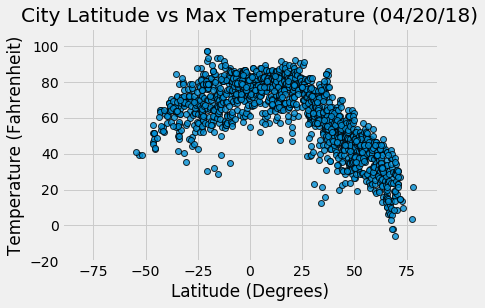

In [31]:
# Build a scatter plot for each data type
plt.scatter(city_data_df["city_lat"],
            city_data_df["city_max_temp"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="City")

# Incorporate the other graph properties
chart_title = f'City Latitude vs Max Temperature ({record_date})'
plt.title(chart_title)
plt.ylabel("Temperature (Fahrenheit)")
plt.xlabel("Latitude (Degrees)")
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([-20, 110])
plt.show()

## Latitude (Degrees) vs Humidity (%)

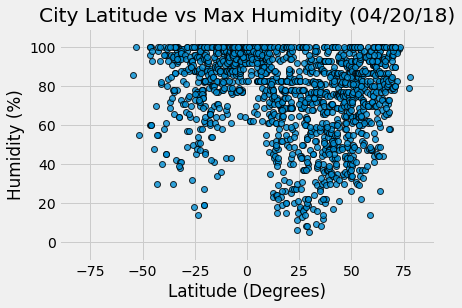

In [29]:
# Build a scatter plot for each data type
plt.scatter(city_data_df["city_lat"],
            city_data_df["city_humidity"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="City")

# Incorporate the other graph properties
chart_title = f'City Latitude vs Max Humidity ({record_date})'
plt.title(chart_title)
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude (Degrees)")
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([-10, 110])
plt.show()

## Latitude (Degrees) vs Cloudiness (%)

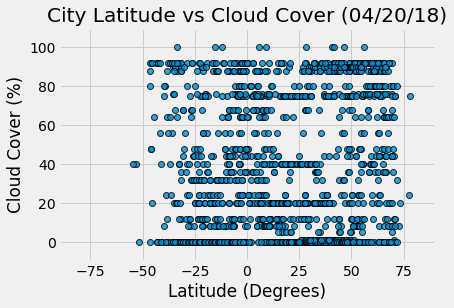

In [32]:
# Build a scatter plot for each data type
plt.scatter(city_data_df["city_lat"],
            city_data_df["city_cloud_cover"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="City")

# Incorporate the other graph properties
chart_title = f'City Latitude vs Cloud Cover ({record_date})'
plt.title(chart_title)
plt.ylabel("Cloud Cover (%)")
plt.xlabel("Latitude (Degrees)")
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([-10, 110])
plt.show()

## Latitude (Degrees) vs Windspeed (MPH)

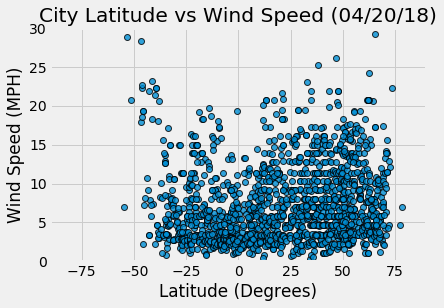

In [36]:
# Build a scatter plot for each data type
plt.scatter(city_data_df["city_lat"],
            city_data_df["city_wind_speed"],
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="City")

# Incorporate the other graph properties
chart_title = f'City Latitude vs Wind Speed ({record_date})'
plt.title(chart_title)
plt.ylabel("Wind Speed (MPH)")
plt.xlabel("Latitude (Degrees)")
plt.grid(True)
plt.xlim([-90, 90])
plt.ylim([0, 30])
plt.show()